In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# generate data
signal_length = 15
signal_repeats = 3
predict_ahead = 1
noise_strength = 0.00
total_series_length = signal_length * signal_repeats

dims = 1
def generateData(signal_length, predict_ahead, signal_repeats, batch_size, noise_strength):
    total_series_length = signal_length*signal_repeats
    x = np.linspace(0, np.pi*2*signal_repeats, total_series_length + predict_ahead, dtype=np.float32)
    x = x.reshape((1, -1, 1))  
    
    # include shift for batches
    x = np.repeat(x, batch_size, 0)
    x += np.random.random(batch_size)[:, None, None] * 10
    y = np.sin(x)
    input_ = y[:, :total_series_length].copy()
    if noise_strength > 0:
        input_ += np.random.normal(size=(input_.shape)) * noise_strength # add some noise to the input
    target = y[:, predict_ahead:]
    return input_ , target 
x, y = generateData(signal_length, predict_ahead, signal_repeats, 1, noise_strength)
# x_i, y_i = x[0, :, 0], y[0, :, 0]
# f, ax = plt.subplots(1)
# ax.plot(x_i, label="input")
# ax.plot(y_i, label="target")
# ax.set_xlabel("time $t$")
# ax.set_ylabel("signal magnitude")
# ax.legend()

In [0]:
#plotting helpter function
# just a helper function to see the progress
def replot(input_series, predictions_series, batchY, f, ax,  input_line, y_line, pred_line, text, iteration, loss):
    y_line.set_xdata(range(total_series_length))
    y_line.set_ydata(batchY)
    pred_line.set_xdata(range(total_series_length))
    pred_line.set_ydata(predictions_series)
    input_line.set_xdata(range(total_series_length))
    input_line.set_ydata(input_series)
    text.set_text(f"Iteration: {iteration} Loss: {loss}")
#     plt.pause(0.25)
    
    # Need both of these in order to rescale
    ax.relim()
    ax.autoscale_view()
    # We need to draw and flush
    f.canvas.draw()
    f.canvas.flush_events()

# 3 Recurrent Neural Networks (30 pts.)
Replace the simple recurrent layer in the `LSDA2020 RNN1.ipynb` notebook with a LSTM
layer. Follow the equations from `LSDA2020 RNN2.ipynb` to implement the LSTM. You will
need to:
1. (10 pts.) add all variables (`tf.Variable`) from the LSTM definition
2. (10 pts.) extend the step and `iterate_series` function
3. (10 pts.) pass on the hidden state $h_t$ and the cell state ct in the training loop andthe `iterate_series` function
Report the new code in the report (insert all changed code cells from the notebook into
the report). Train the new model, **report the training loss and also attach the figure of
the learned prediction.**
Note: You can initialize the cell state c0 to zero (same as for h0) and do not need to
learn it.

In [0]:
#3.1
#Learnable weights and biases
rnn_mode = True
learn_h0 = True
n_iterations = 250
truncated_backprop_length = 45
num_neurons = 8
batch_size = 5
lr = 0.01

In [0]:
W_f = tf.Variable(np.random.rand(dims, num_neurons), dtype=tf.float32)
b_f = tf.Variable(np.zeros((1, num_neurons)), dtype=tf.float32)
U_f = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)
W_i = tf.Variable(np.random.rand(dims, num_neurons), dtype=tf.float32)
b_i = tf.Variable(np.zeros((1, num_neurons)), dtype=tf.float32)
U_i = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)
W_j = tf.Variable(np.random.rand(dims, num_neurons), dtype=tf.float32)
b_j = tf.Variable(np.zeros((1, num_neurons)), dtype=tf.float32)
U_j = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)
W_o = tf.Variable(np.random.rand(dims, num_neurons), dtype=tf.float32)
b_o = tf.Variable(np.zeros((1, num_neurons)), dtype=tf.float32)
U_o = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)
# if rnn_mode:
#     U_h = tf.Variable(np.random.rand(num_neurons, num_neurons), dtype=tf.float32)
# else:
#     U_h = tf.Variable(np.zeros((num_neurons, num_neurons)), dtype=tf.float32)

# initial hidden state
h_0 = tf.Variable(np.zeros((1, num_neurons), dtype=np.float32))
c_0 = tf.Variable(np.zeros((1, num_neurons), dtype=np.float32))

In [0]:
# fully connected layer
W_y = tf.Variable(np.random.rand(num_neurons, dims), dtype=tf.float32)
b_y = tf.Variable(np.zeros((1, dims)), dtype=tf.float32)

RNN:
$ \mathbf{h}_t \leftarrow \sigma_h \bigl( W_h \cdot \mathbf{x}_t + U_h \cdot \mathbf{h}_{t-1} + \mathbf{b}_h \bigr) $

$ \hat{\mathbf{y}}_t \leftarrow \sigma_y \bigl( W_y \cdot \mathbf{h}_t + \mathbf{b}_y \bigr) $
LSTM:
## **Definition**

|||
|-------------|---------------------------------------------------------------------|
|hidden state | $\mathbf{h}_t \leftarrow \mathbf{o}_t \circ \sigma_h(\mathbf{c}_t)$ |
|cell state   | $\mathbf{c}_t \leftarrow \mathbf{f}_t \circ \mathbf{c}_{t-1} + \mathbf{i}_t \circ \mathbf{j}_t $ |
|output gate  | $\mathbf{o}_t \leftarrow \sigma_o(W_o \cdot \mathbf{x}_t + U_o \cdot \mathbf{h}_{t-1} + \mathbf{b}_o)$ |
|forget gate  | $\mathbf{f}_t \leftarrow \sigma_f(W_f \cdot \mathbf{x}_t + U_f \cdot \mathbf{h}_{t-1} + \mathbf{b}_f)$ |
|input gate   | $\mathbf{i}_t \leftarrow \sigma_i(W_i \cdot \mathbf{x}_t + U_i \cdot \mathbf{h}_{t-1} + \mathbf{b}_i)$|
|modulation gate| $\mathbf{j}_t \leftarrow \sigma_j(W_j \cdot \mathbf{x}_t + U_j \cdot \mathbf{h}_{t-1} + \mathbf{b}_j)$ |

- $W \in \mathbb{R}^{m \times d}$ weight matrices for input vector $\mathbf{x}_t$
- $U \in \mathbb{R}^{m \times m}$ weight matrices for hidden state vector $\mathbf{h}_{t-1}$
- activation functions $\sigma_h$ and $\sigma_j$ are usually $tanh$
- activation functions $\sigma_f$, $\sigma_i$, and $\sigma_o$ are usually $sigmoid$
- element-wise multiplication is $\circ$
    * important for gating (all values between usually between -1 and 1 (tanh) or 0 and 1 (sigmoid)
- cell state $\mathbf{c}$ : stores contextual and longer term information
- hidden state $\mathbf{h}$ : stores immediately necessary information and **is given to next layer**

In [0]:
@tf.function
def step(x_t, h, c):
    # forget layer
    f = tf.nn.sigmoid(
        tf.matmul(x_t, W_f) + tf.matmul(h, U_f) + b_f
    )
    # input layer:
    i = tf.nn.sigmoid(
        tf.matmul(x_t, W_i) + tf.matmul(h, U_i) + b_i
    )
    # modulation layer:
    j = tf.nn.tanh(
        tf.matmul(x_t, W_j) + tf.matmul(h, U_j) + b_j
    )
    # output layer:
    o = tf.nn.sigmoid(
        tf.matmul(x_t, W_o) + tf.matmul(h, U_o) + b_o
    )
    # memory (cell) layer:
    c = f*c + i*j
    #c = tf.matmul(c, f) + tf.matmul(j, i)
    # hidden state 
    h = o * tf.nn.tanh(c)
    #h = tf.matmul(o, tf.nn.tanh(c))
    y_hat = h
    return y_hat, h, c

@tf.function
def iterate_series(x, h, c):
    y_hat = []
    # iterate over time axis (1)
    for j in range(x.shape[1]):
        # give previous hidden state and input from the current time step
        y_hat_t, h, c = step(x[:, j], h, c)
        y_hat.append(y_hat_t)
    y_hat = tf.stack(y_hat, 1)
    return y_hat, h, c

# @tf.function
# def step(x_t, h):
#     # rnn layer
#     h = tf.nn.tanh(
#         tf.matmul(x_t, W_h) + tf.matmul(h, U_h) + b_h
#     )
#     # fully connected
#     y_hat = tf.matmul(h, W_y) + b_y
#     return y_hat, h #returning prediction and hidden state

# @tf.function
# def iterate_series(x, h):
#     y_hat = []
#     # iterate over time axis (1)
#     for j in range(x.shape[1]):
#         # give previous hidden state and input from the current time step
#         y_hat_t, h = step(x[:, j], h)
#         y_hat.append(y_hat_t)
#     y_hat = tf.stack(y_hat, 1)
#     return y_hat, h

In [0]:
# backpropagation
trainable_vars = [W_f, U_f, b_f, W_i, U_i, b_i, W_j, U_j, b_j, W_o, U_o, b_o]
#trainable_vars.append(h_0, c_0)

#trainable_vars = [W_h, U_h, b_h, W_y, b_y] #*for rnn
# if rnn_mode:
#     trainable_vars.append(U_h)
# if learn_h0:
#     trainable_vars.append(h_0)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

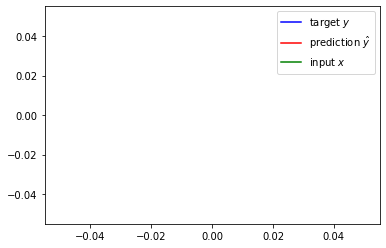

In [12]:
# training
plt.ion()
f, ax = plt.subplots(1)
y_line, = ax.plot([],[], color="blue", label="target $y$")
pred_line, = ax.plot([],[], color="red", label="prediction $\haty$")
input_line, = ax.plot([],[], color="green", label="input $x$")
text = ax.text(0, 1, "", )
ax.legend(loc='upper right')

# train for a set number of iterations
for iteration in range(n_iterations):
    # generates a long time series / normally loaded from dataset (e.g. stocks, weather)
    x, y = generateData(signal_length, predict_ahead, signal_repeats, batch_size, noise_strength)
    h = None
    predictions = None
    loss_list = []
    grads = None
    
    # do not feed complete series, but chunks of it (truncated_backprop_length)
    for i in range(0, total_series_length, truncated_backprop_length):
        
        with tf.GradientTape() as tape:
            if h is None:
                # initialize hidden state (h_0) -> new shape (batch_size, num_neurons)
                h = tf.repeat(h_0, batch_size, 0)
                c = tf.repeat(c_0, batch_size, 0) #added
            x_part = x[:, i: i + truncated_backprop_length]
            y_part = y[:, i: i + truncated_backprop_length]
            
            # get predictions for this part (forward pass)
            #y_hat, h = iterate_series(x_part, h)
            y_hat, h, c = iterate_series(x_part, h, c)
        
            # calculate mean squared error
            loss = tf.reduce_mean((y_hat - y_part)**2)        
        # backprop
        if grads is None:
            grads = tape.gradient(loss, trainable_vars)
        else:
            grads = grads + tape.gradient(loss, trainable_vars)
                           
        loss_list.append(loss)
        # combine with previous predictions
        predictions = tf.concat([predictions, y_hat], 1) if predictions is not None else y_hat
    
    # finally we are adapting the weights
    optimizer.apply_gradients(zip(grads, trainable_vars))
        
#     print("Iteration", iteration, "Loss", np.mean(loss_list))  
    #replot(x[0], predictions[0], y[0], f, ax, input_line, y_line, pred_line, text, iteration, np.mean(loss_list))

# Recurrent Neural Networks in Keras (30 pts.)
Add different components to the RNN from LSDA2020 RNN2.ipynb and test the new mod-
els (each bullet point is a new separate model). The number of neuron can stay the same
for all layers (default was 64). Report the mean validation error and the changed parts
with a bit of context in the code (e.g. complete model or optimizer definition). Also,
provide a model overview with model.summary() for each new model (not necessary for
gradient clipping).
1. (7 pts.) Replace the LSTM layer with a Bidirectional-LSTM. Bidirectional sequence processing is possible with tf.keras.layers.Bidirectional.
2. (4 pts.) Stack 2 LSTM layers (you may need to use the return sequences parameter).
 * (4 pts.) Detail the difference to bidirectional processing (max. 2-3 sentences).
3. (7 pts.) Add a 1-d convolution layer (tf.keras.layers.Conv1D) with a kernel size of 3 and stride of 1 before the recurrent part. You will need to reshape the data with tf.keras.layers.Reshape.
 * (5 pts.) Explain the difference between how a convolutional layer process time series and how a recurrent model does it (max 4-5 sentences).
4. (3 pts.) Gradient clipping can be a helpful to train recurrent networks. Keras offers to clip gradients directly through the optimizer. Change the optimizer to clip the gradients to 1.
It is more important here to show that you correctly changed the model (by showing the
corresponding code in the report) or optimizer than improving the results.

In [0]:
# import some layer
from tensorflow.keras.layers import SimpleRNN, Input, Dense, LSTM, GRU, AveragePooling1D, TimeDistributed, Bidirectional, Conv1D, Flatten, Layer, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import activations, initializers
INPUT_SHAPE = (100, 22)

In [14]:
# Exercise 4.1
def get_model_bidirectional(shape= INPUT_SHAPE):
    inp = Input(shape)
    x = Bidirectional(LSTM(64))(inp)
    x = Dense(1)(x)
    model = Model(inp, x)
    return model

get_model_bidirectional().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 22)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               44544     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 44,673
Trainable params: 44,673
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Exercise 4.2
def get_stacked_LSTM(shape= INPUT_SHAPE):
    inp = Input(shape)
    x = LSTM(64, return_sequences=True)(inp)
    x = LSTM(64, go_backwards=True)(x)
    x = Dense(1)(x)
    model = Model(inp, x)
    return model

get_stacked_LSTM().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 22)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           22272     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 55,361
Trainable params: 55,361
Non-trainable params: 0
_________________________________________________________________


##  Detail the difference to bidirectional processing (max. 2-3 sentences
The bidirectional layers outputs two concatenated LSTM layers, while the stacked layers output one single LSTM layer. In the stacked layer, the input of the backward layer is affected by the forward layer since it passes through the forward lyer, but the two layers are indepdedant in the bidirectional layer.

In [16]:
#Add a 1-d convolution layer (tf.keras.layers.Conv1D) with a kernel size of 3 and stride of 1 before the recurrent part. 
#You will need to reshape the data with tf.keras.layers.Reshape. ??????????
# Exercise 4.3
def get_model_convolutional(shape = INPUT_SHAPE):
    inp = Input(shape)
    x = Conv1D(filters=32, kernel_size=3, strides=1)(inp)
    x = LSTM(64, return_sequences=False)(x)
    x = Dense(1)(x)
    model = Model(inp, x)
    return model
get_model_convolutional().summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 22)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 32)            2144      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 27,041
Trainable params: 27,041
Non-trainable params: 0
_________________________________________________________________


A recurrent nueral network uses every piece of the input data to make a predictiion. A convolutional neural network extracts features from the input data a subset of the input data and uses the features to make a prediction. Not all input data may be necessary to makea good prediction therefore CNNs can be less comoutationally exensive.

In [0]:
# Exercise 4.4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipvalue=1)
get_model_convolutional().compile(optimizer, loss='mae')

In [18]:
def get_model_rnn(shape = INPUT_SHAPE):
    inp = Input(shape)
    x = LSTM(64, return_sequences=False)(inp)
    x = Dense(1)(x)
    model = Model(inp, x)
    return model
get_model_rnn().summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100, 22)]         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                22272     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 22,337
Trainable params: 22,337
Non-trainable params: 0
_________________________________________________________________
